In [1]:
import cv2
import numpy as np
import random 
import matplotlib.pyplot as plt
import os
import pandas as pd
%matplotlib inline 
from skimage import transform, filters
import numpy as np
from skimage import io, color, util
from skimage.feature import greycomatrix
from sklearn import svm, ensemble, tree, naive_bayes
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
import h5py

h5filepath = r"C:\Users\user\OneDrive - mmu.edu.my\Documents\University\MMU\Class\Computer_Vision_CV2\Project1\Project\data.h5"

# read the dataset from h5 file and save into variables
file = h5py.File(h5filepath, 'r')
X = np.array(file['/data']).astype('uint8')
y = np.array(file['/label']).astype('uint8')

class_name = ['Grade_AA','Grade_B', 'Grade_D']
# # reshape the data
# X = X.reshape(len(X), -1)
# y = Y.reshape(-1)

print(X.shape)
print(y.shape)

(540, 1000, 1000)
(540,)


In [3]:
X_resized = []

for i in X:
    resized = cv2.resize(i, dsize=(360, 360))
    X_resized.append(resized)

print(X_resized)

[array([[14, 16, 14, ..., 16, 16, 12],
       [10, 14, 16, ..., 17, 17, 17],
       [15, 14, 12, ..., 15, 18, 18],
       ...,
       [18, 20, 18, ..., 13, 19, 17],
       [22, 18, 19, ..., 14, 19, 18],
       [20, 19, 18, ..., 14, 16, 16]], dtype=uint8), array([[ 7,  9,  8, ...,  9,  9,  9],
       [ 7,  7,  6, ..., 10,  9,  9],
       [ 6,  6,  6, ...,  9,  9,  8],
       ...,
       [ 4,  6,  7, ...,  8,  9,  7],
       [ 6, 11,  8, ...,  6,  7,  6],
       [ 8,  7, 12, ...,  6,  6,  9]], dtype=uint8), array([[ 5,  5,  5, ...,  3,  3,  4],
       [ 6,  5,  6, ...,  4,  4,  3],
       [ 6,  6,  6, ...,  4,  4,  3],
       ...,
       [ 6,  8, 12, ...,  9,  8,  9],
       [11,  6,  7, ..., 10, 11, 11],
       [12, 15, 15, ..., 12, 13, 12]], dtype=uint8), array([[ 6,  6,  6, ..., 14, 11, 15],
       [ 7,  5,  6, ..., 12, 12, 13],
       [ 6,  5,  7, ..., 13, 14, 11],
       ...,
       [ 4,  8, 10, ...,  6,  6,  7],
       [ 5,  5,  5, ...,  6,  6,  7],
       [ 7,  6,  6, ...,  6,  7,

In [4]:
print(X_resized[2].shape)

(360, 360)


1


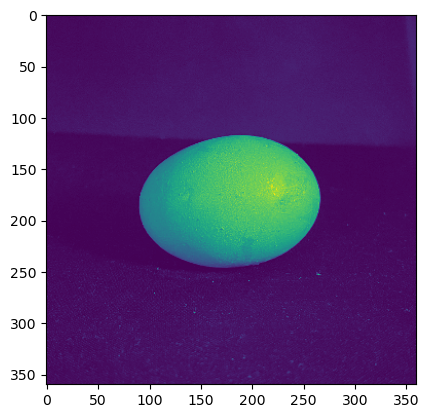

In [5]:
X = X_resized

print(y[3])
plt.imshow(X[3])

In [6]:
from sklearn.model_selection import KFold

X = np.array(X)
y = np.array(y)

# Create a KFold object
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Use the KFold object to generate the training and testing sets
for train_index, test_index in kf.split(X):
    X_train_ori, X_test_ori = X[train_index], X[test_index]
    y_train_ori, y_test_ori = y[train_index], y[test_index]
    # Now you can create and evaluate your models using these training and testing sets

In [7]:
print(X_train_ori.shape)
print(y_train_ori.shape)
print(X_test_ori.shape)
print(y_test_ori.shape)

(486, 360, 360)
(486,)
(54, 360, 360)
(54,)


# Augmentation

In [8]:
import numpy as np
from skimage import transform, util, color

augmented = []

# Get an index for each category
unique_classes = np.unique(y_train_ori)
class_indices = [np.where(y_train_ori == c)[0] for c in unique_classes]

# Determine the number of samples to be data-enhanced for each category
augmented_samples_per_class = int(1.0 * len(X_train_ori) / len(unique_classes))

# Perform data augmentation for each category and add the augmented samples back to the training set
for indices in class_indices:
    # Randomly select the samples to be augmented from each category
    selected_indices = np.random.choice(indices, size=augmented_samples_per_class, replace=True)
    
    for index in selected_indices:
        image = X_train_ori[index]
        
        # Rotate
        rotated_image = transform.rotate(image, angle=90, mode='reflect')
        
        # Salt pepper noise
        salt_noisy_rotated_image = util.img_as_ubyte(util.random_noise(rotated_image, mode='s&p', amount=0.02))
        
        augmented.append(salt_noisy_rotated_image)
        
        # Replace the augmented samples directly with the corresponding samples in the original training set
        X_train_ori[index] = rotated_image

In [9]:
print(len(augmented))
print(len(X_train_ori))
print(len(y_train_ori))

486
486
486


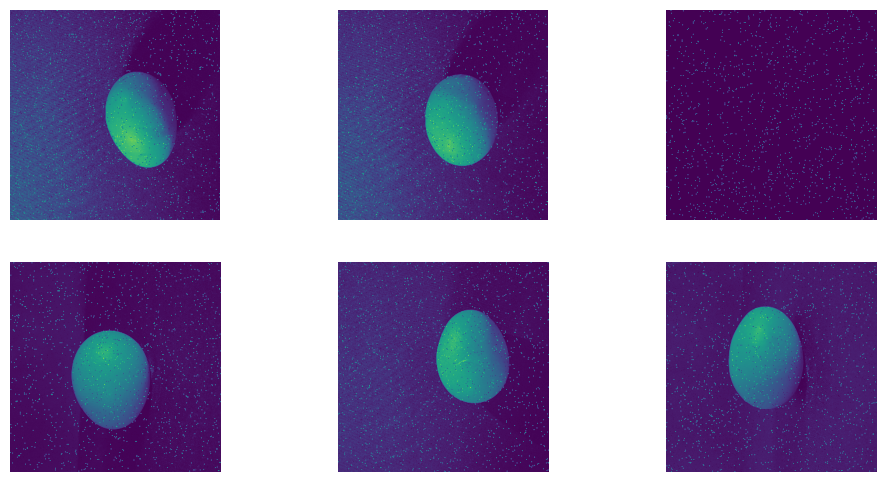

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(augmented[i])
    ax.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.show()

In [11]:
# reshape the data
X_train = X_train_ori.reshape(len(X_train_ori), -1)
y_train = y_train_ori.reshape(-1)
X_test = X_test_ori.reshape(len(X_test_ori), -1)
y_test = y_test_ori.reshape(-1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(486, 129600)
(486,)
(54, 129600)
(54,)


In [12]:
# SVM
svm_classifier = svm.SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")

SVM Accuracy: 96.30%


In [13]:
# Random Forest
rf_classifier = ensemble.RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

Random Forest Accuracy: 98.15%


In [14]:
# Decision Tree
dt_classifier = tree.DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
dt_predictions = dt_classifier.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy * 100:.2f}%")

Decision Tree Accuracy: 75.93%


In [15]:
# Naive Bayes
nb_classifier = naive_bayes.GaussianNB()
nb_classifier.fit(X_train, y_train)
nb_predictions = nb_classifier.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy * 100:.2f}%")

Naive Bayes Accuracy: 61.11%


# Feature Extraction - GLCM

In [16]:
X_train = X_train_ori
y_train = y_train_ori
X_test = X_test_ori
y_test = y_test_ori

In [17]:
from skimage.feature import greycomatrix, greycoprops
import numpy as np

In [18]:
def extract_glcm_features(image, distances=[5], angles=[0], levels=256):
    # Compute the GLCM of the image
    glcm = greycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    
    # Compute GLCM properties and return as features
    features = [
        np.mean(greycoprops(glcm, 'contrast')),
        np.mean(greycoprops(glcm, 'dissimilarity')),
        np.mean(greycoprops(glcm, 'homogeneity')),
        np.mean(greycoprops(glcm, 'energy')),
        np.mean(greycoprops(glcm, 'correlation'))
    ]
    
    return features

In [19]:
x_train_glcm = np.array([extract_glcm_features(img) for img in X_train])
x_test_glcm = np.array([extract_glcm_features(img) for img in X_test])


C:\Users\user\anaconda3\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\user\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\user\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\user\anaconda3\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\user\anaconda3\lib\site-packa

In [20]:
# SVM
svm_classifier = svm.SVC(kernel='linear', C=1.0)
svm_classifier.fit(x_train_glcm, y_train)
svm_predictions = svm_classifier.predict(x_test_glcm)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")

SVM Accuracy: 31.48%


In [21]:
# Random Forest
rf_classifier = ensemble.RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train_glcm, y_train)
rf_predictions = rf_classifier.predict(x_test_glcm)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

Random Forest Accuracy: 62.96%


In [22]:
# Decision Tree
dt_classifier = tree.DecisionTreeClassifier(random_state=42)
dt_classifier.fit(x_train_glcm, y_train)
dt_predictions = dt_classifier.predict(x_test_glcm)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy * 100:.2f}%")

Decision Tree Accuracy: 64.81%


In [23]:
# Naive Bayes
nb_classifier = naive_bayes.GaussianNB()
nb_classifier.fit(x_train_glcm, y_train)
nb_predictions = nb_classifier.predict(x_test_glcm)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy * 100:.2f}%")

Naive Bayes Accuracy: 38.89%


# Prepprocessing - HE

In [29]:
X_train = X_train_ori
y_train = y_train_ori
X_test = X_test_ori
y_test = y_test_ori

In [30]:
def histogram_equalization(img):
    return cv2.equalizeHist(img)

In [32]:
# Apply histogram equalization to each image in the training and test sets and convert them to one-dimensional arrays
x_train_he = np.array([histogram_equalization(img).ravel() for img in X_train])
x_test_he = np.array([histogram_equalization(img).ravel() for img in X_test])


In [33]:
# SVM
svm_classifier = svm.SVC(kernel='linear', C=1.0)
svm_classifier.fit(x_train_he, y_train)
svm_predictions = svm_classifier.predict(x_test_he)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")

SVM Accuracy: 100.00%


In [34]:
# Random Forest
rf_classifier = ensemble.RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train_he, y_train)
rf_predictions = rf_classifier.predict(x_test_he)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

Random Forest Accuracy: 100.00%


In [35]:
# Decision Tree
dt_classifier = tree.DecisionTreeClassifier(random_state=42)
dt_classifier.fit(x_train_he, y_train)
dt_predictions = dt_classifier.predict(x_test_he)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy * 100:.2f}%")

Decision Tree Accuracy: 81.48%


In [36]:
# Naive Bayes
nb_classifier = naive_bayes.GaussianNB()
nb_classifier.fit(x_train_he, y_train)
nb_predictions = nb_classifier.predict(x_test_he)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy * 100:.2f}%")

Naive Bayes Accuracy: 50.00%
